# Fraud Transaction Analysis
Analysis of fraud patterns in transaction data with key visualizations

 ## Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

def load_and_prepare_data(file_path):
    """Load and prepare transaction data for analysis"""
    df = pd.read_csv(file_path)

    # Convert amount column to numeric
    df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

    # Convert dates
    df['Post Date'] = pd.to_datetime(df['Post Date'], errors='coerce')
    df['Account Open Date'] = pd.to_datetime(df['Account Open Date'], errors='coerce')

    # Create fraud indicator
    df['Is_Fraud'] = df['Fraud Adjustment Indicator'].notna() & (df['Fraud Adjustment Indicator'].str.strip() != '')

    # Clean IDs
    df['Member ID'] = df['Member ID'].astype(str).str.lstrip('0')
    df['Account ID'] = df['Account ID'].astype(str).str.lstrip('0')

    # Basic statistics
    total_transactions = len(df)
    fraud_cases = df['Is_Fraud'].sum()
    fraud_rate = fraud_cases / total_transactions * 100

    print(f"Dataset Overview:")
    print(f"- Total transactions: {total_transactions:,}")
    print(f"- Fraud cases: {fraud_cases:,}")
    print(f"- Fraud rate: {fraud_rate:.4f}%")
    print(f"- Date range: {df['Post Date'].min().strftime('%Y-%m-%d')} to {df['Post Date'].max().strftime('%Y-%m-%d')}")
    print(f"- Unique accounts: {df['Account ID'].nunique():,}")
    print(f"- Unique members: {df['Member ID'].nunique():,}")

    return df

# Load data
file_path = '../data/transaction_data.csv'
df = load_and_prepare_data(file_path)

# Display basic info
print(f"\nDataset shape: {df.shape}")
display(df.head())

Dataset Overview:
- Total transactions: 604,432
- Fraud cases: 378
- Fraud rate: 0.0625%
- Date range: 2024-09-01 to 2025-09-01
- Unique accounts: 1,953
- Unique members: 1,952

Dataset shape: (604432, 14)


,Account ID,Member ID,Account Type,Account Open Date,Member Age,Product ID,Post Date,Post Time,Amount,Action Type,Source Type,Transaction Description,Fraud Adjustment Indicator,Is_Fraud
0,6190877696,15336793,General Membership,2007-12-15,46,0007,2024-09-01,35,24.37,Withdrawal,Signature,APPLE.COM/BILL,NaN,False
1,8892002798,878709545,General Membership,2023-05-22,28,0007,2024-09-01,45,5.68,Withdrawal,Signature,LOVE'S #0679 INSIDE,NaN,False
2,8015188961,576034980,General Membership,2021-07-28,60,0007,2024-09-01,51,55.00,Withdrawal,Signature,CASH APP*ANITA,NaN,False
3,2272989105,210401436,General Membership,2006-04-05,54,0007,2024-09-01,110,5.00,Withdrawal,Online Banking,Transfer To *1775,NaN,False
4,7798496057,929194557,General Membership,2021-08-16,44,0007,2024-09-01,132,318.76,Withdrawal,Signature,AMAZON MKTPL*RK6Y33M30,NaN,False


## Fraud Amount Analysis

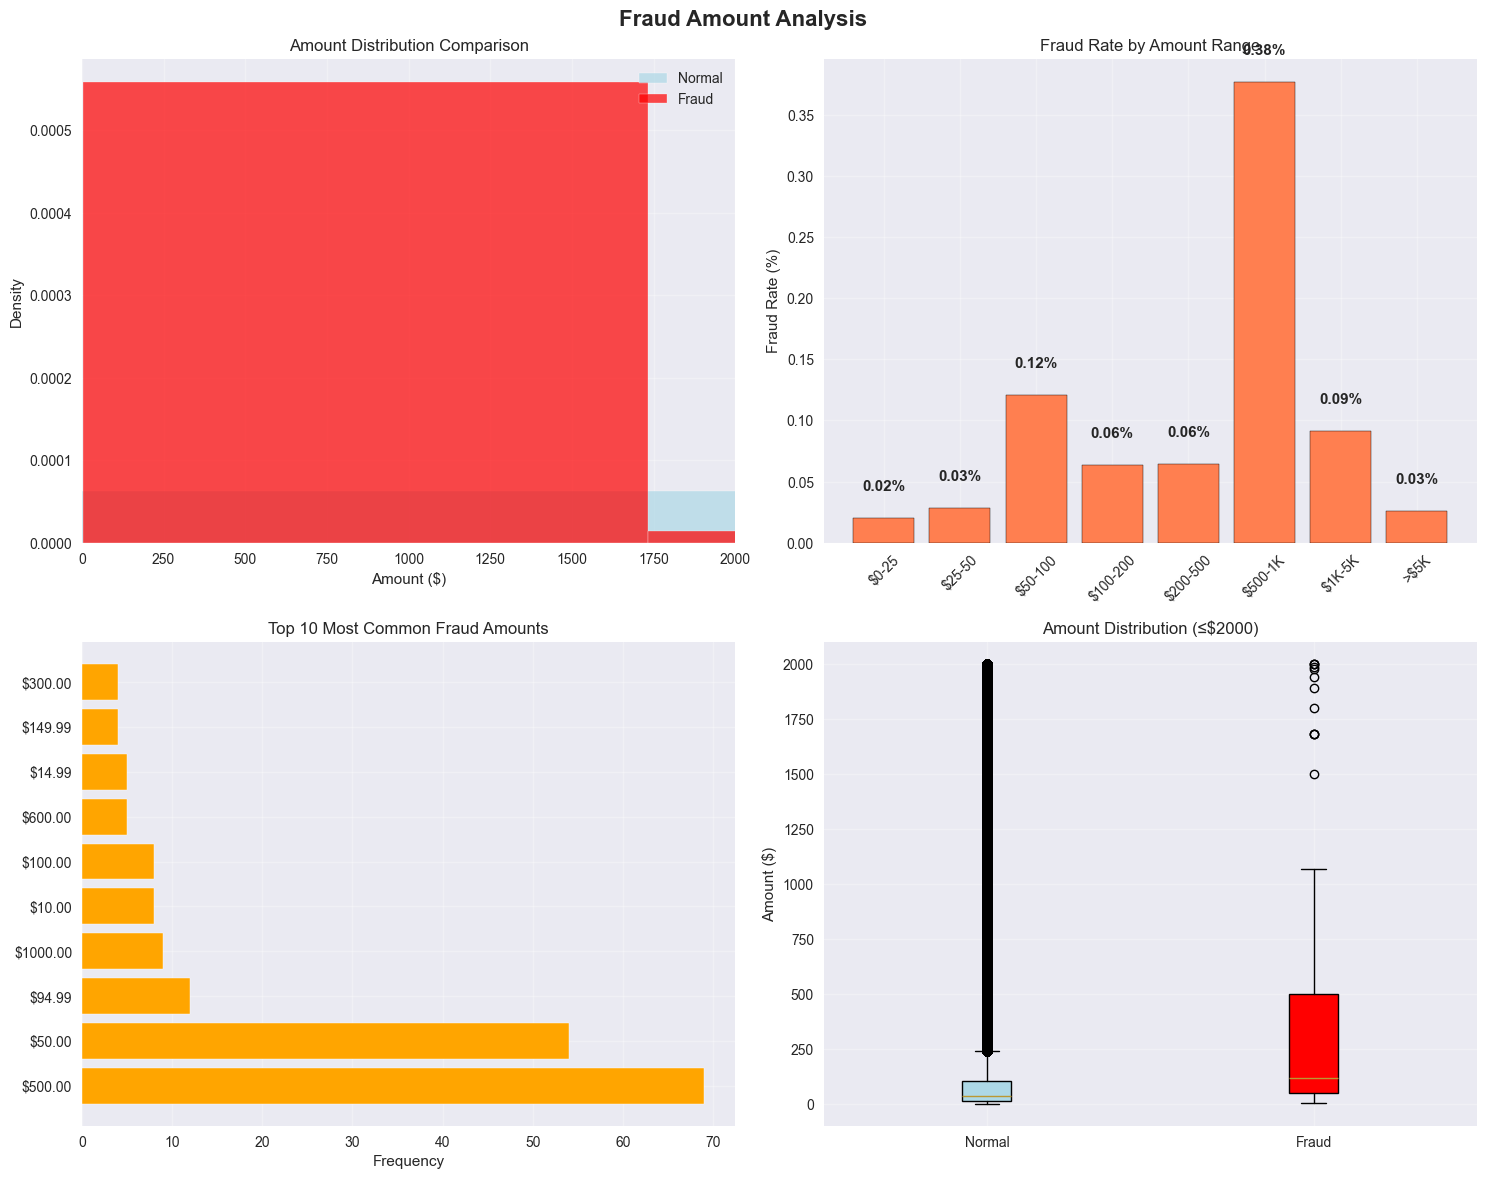


Fraud Amount Statistics:
- Total fraud cases: 378
- Amount range: $2.13 - $86,500.00
- Mean: $567.19
- Median: $120.00
- Total fraud amount: $214,399.30


In [2]:
def analyze_fraud_amounts(df):
    """Analyze fraud amount patterns"""
    fraud_df = df[df['Is_Fraud']].copy()
    normal_df = df[~df['Is_Fraud']].copy()

    # Amount ranges analysis
    bins = [0, 25, 50, 100, 200, 500, 1000, 5000, float('inf')]
    labels = ['$0-25', '$25-50', '$50-100', '$100-200', '$200-500', '$500-1K', '$1K-5K', '>$5K']

    fraud_df['Amount_Range'] = pd.cut(fraud_df['Amount'], bins=bins, labels=labels, right=False)
    df['Amount_Range'] = pd.cut(df['Amount'], bins=bins, labels=labels, right=False)

    fraud_by_range = fraud_df['Amount_Range'].value_counts().sort_index()
    total_by_range = df['Amount_Range'].value_counts().sort_index()
    fraud_rate_by_range = (fraud_by_range / total_by_range * 100).fillna(0)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fraud Amount Analysis', fontsize=16, fontweight='bold')

    # 1. Amount distribution comparison
    axes[0, 0].hist(normal_df['Amount'], bins=50, alpha=0.7, label='Normal', density=True, color='lightblue')
    axes[0, 0].hist(fraud_df['Amount'], bins=50, alpha=0.7, label='Fraud', density=True, color='red')
    axes[0, 0].set_xlabel('Amount ($)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Amount Distribution Comparison')
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 2000)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Fraud rate by amount range
    bars = axes[0, 1].bar(range(len(fraud_rate_by_range)), fraud_rate_by_range.values,
                          color='coral', edgecolor='black')
    axes[0, 1].set_xticks(range(len(labels)))
    axes[0, 1].set_xticklabels(labels, rotation=45)
    axes[0, 1].set_ylabel('Fraud Rate (%)')
    axes[0, 1].set_title('Fraud Rate by Amount Range')
    axes[0, 1].grid(True, alpha=0.3)
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                        f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

    # 3. Top fraud amounts
    top_fraud_amounts = fraud_df['Amount'].value_counts().head(10)
    if len(top_fraud_amounts) > 0:
        bars = axes[1, 0].barh(range(len(top_fraud_amounts)), top_fraud_amounts.values, color='orange')
        axes[1, 0].set_yticks(range(len(top_fraud_amounts)))
        axes[1, 0].set_yticklabels([f'${x:.2f}' for x in top_fraud_amounts.index])
        axes[1, 0].set_xlabel('Frequency')
        axes[1, 0].set_title('Top 10 Most Common Fraud Amounts')
        axes[1, 0].grid(True, alpha=0.3)

    # 4. Box plot comparison
    box_data = [normal_df['Amount'][normal_df['Amount'] <= 2000],
                fraud_df['Amount'][fraud_df['Amount'] <= 2000]]
    box_plot = axes[1, 1].boxplot(box_data, labels=['Normal', 'Fraud'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('red')
    axes[1, 1].set_ylabel('Amount ($)')
    axes[1, 1].set_title('Amount Distribution (≤$2000)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print key statistics
    print(f"\nFraud Amount Statistics:")
    print(f"- Total fraud cases: {len(fraud_df):,}")
    print(f"- Amount range: ${fraud_df['Amount'].min():.2f} - ${fraud_df['Amount'].max():,.2f}")
    print(f"- Mean: ${fraud_df['Amount'].mean():.2f}")
    print(f"- Median: ${fraud_df['Amount'].median():.2f}")
    print(f"- Total fraud amount: ${fraud_df['Amount'].sum():,.2f}")

    return fraud_df

fraud_df = analyze_fraud_amounts(df)

## Fraud Victim Age Analysis

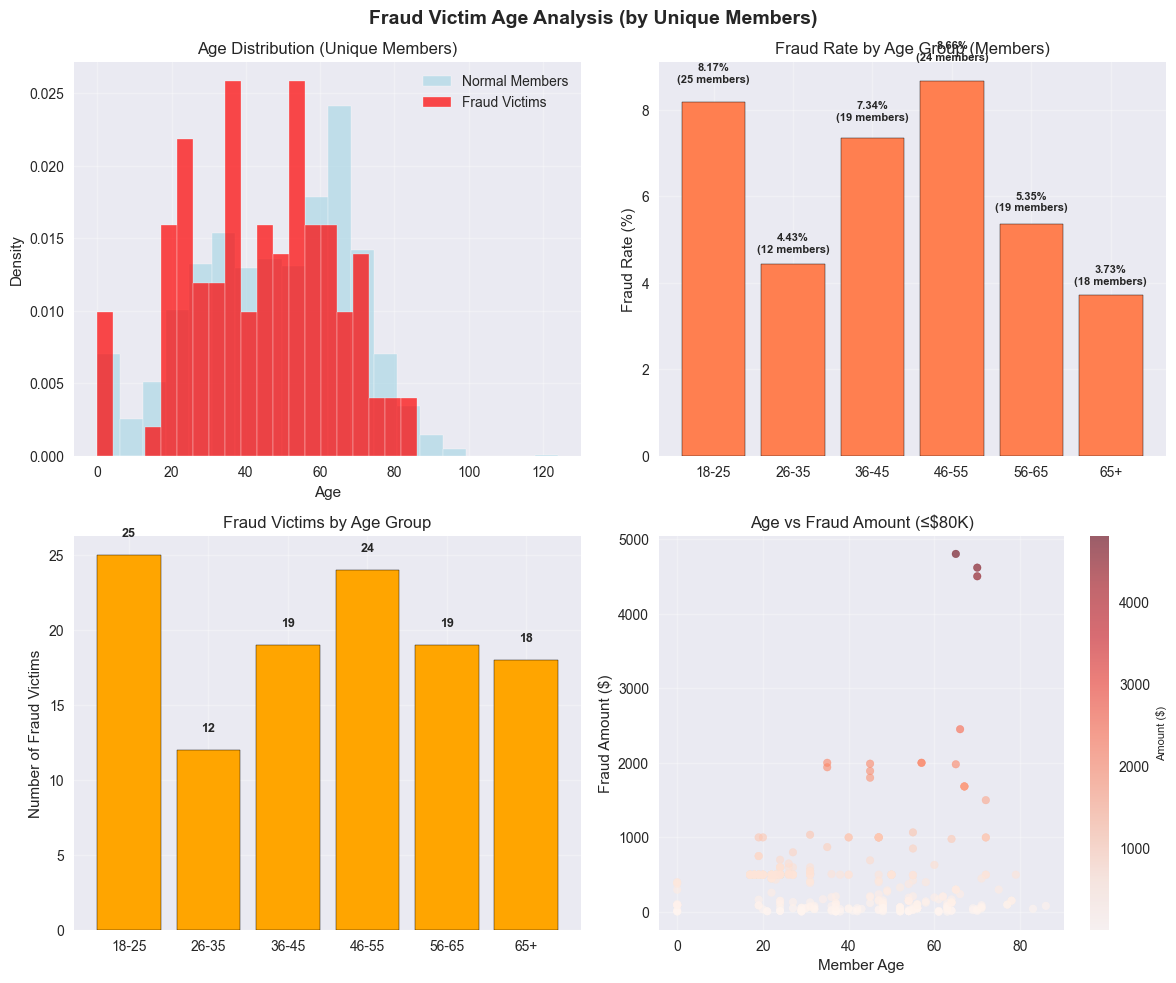


Fraud Victim Demographics (Unique Members):
- Total unique members: 1,952
- Total fraud victims: 117
- Overall victim rate: 5.99%
- Victim age range: 0 - 86
- Average victim age: 43.9
- Median victim age: 45.0

Age Group Analysis (by Unique Members):
- 18-25: 25 victims / 306 members (8.17% rate)
- 26-35: 12 victims / 271 members (4.43% rate)
- 36-45: 19 victims / 259 members (7.34% rate)
- 46-55: 24 victims / 277 members (8.66% rate)
- 56-65: 19 victims / 355 members (5.35% rate)
- 65+: 18 victims / 483 members (3.73% rate)


In [10]:
def analyze_fraud_demographics(df):
    """Analyze fraud patterns by age demographics - based on unique members"""

    # Group by Member ID to get unique individuals
    # For each member, determine if they have any fraud cases
    member_analysis = df.groupby('Member ID').agg({
        'Is_Fraud': 'any',  # True if member has any fraud cases
        'Member Age': 'first',  # Age should be consistent for same member
        'Amount': ['sum', 'count']  # Total amount and transaction count
    }).reset_index()

    # Flatten column names
    member_analysis.columns = ['Member_ID', 'Has_Fraud', 'Member_Age', 'Total_Amount', 'Transaction_Count']

    # Separate fraud victims and normal members
    fraud_members = member_analysis[member_analysis['Has_Fraud']].copy()
    normal_members = member_analysis[~member_analysis['Has_Fraud']].copy()

    # Age group analysis
    age_bins = [0, 25, 35, 45, 55, 65, 100]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']

    member_analysis['Age_Group'] = pd.cut(member_analysis['Member_Age'], bins=age_bins, labels=age_labels, right=False)
    fraud_members['Age_Group'] = pd.cut(fraud_members['Member_Age'], bins=age_bins, labels=age_labels, right=False)
    normal_members['Age_Group'] = pd.cut(normal_members['Member_Age'], bins=age_bins, labels=age_labels, right=False)

    # Calculate age group statistics by unique members
    age_stats = []
    for age_group in age_labels:
        age_members = member_analysis[member_analysis['Age_Group'] == age_group]
        fraud_age_members = age_members[age_members['Has_Fraud']]
        if len(age_members) > 0:
            fraud_rate = len(fraud_age_members) / len(age_members) * 100
            age_stats.append({
                'age_group': age_group,
                'fraud_members': len(fraud_age_members),
                'total_members': len(age_members),
                'fraud_rate': fraud_rate
            })

    # Filter out outliers for scatter plot (remove amounts > 80000)
    fraud_transactions = df[df['Is_Fraud'] & (df['Amount'] <= 80000)].copy()

    # Create visualization with smaller size
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Fraud Victim Age Analysis (by Unique Members)', fontsize=14, fontweight='bold')

    # 1. Age distribution comparison by unique members
    axes[0, 0].hist(normal_members['Member_Age'].dropna(), bins=20, alpha=0.7,
                    label='Normal Members', density=True, color='lightblue')
    axes[0, 0].hist(fraud_members['Member_Age'].dropna(), bins=20, alpha=0.7,
                    label='Fraud Victims', density=True, color='red')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Age Distribution (Unique Members)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Fraud rate by age group (based on unique members)
    age_groups = [item['age_group'] for item in age_stats]
    fraud_rates = [item['fraud_rate'] for item in age_stats]
    fraud_member_counts = [item['fraud_members'] for item in age_stats]

    bars = axes[0, 1].bar(age_groups, fraud_rates, color='coral', edgecolor='black')
    axes[0, 1].set_ylabel('Fraud Rate (%)')
    axes[0, 1].set_title('Fraud Rate by Age Group (Members)')
    axes[0, 1].grid(True, alpha=0.3)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width() / 2., height + height * 0.05,
                        f'{height:.2f}%\n({fraud_member_counts[i]} members)',
                        ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 3. Fraud victim count by age group
    bars = axes[1, 0].bar(age_groups, fraud_member_counts, color='orange', edgecolor='black')
    axes[1, 0].set_ylabel('Number of Fraud Victims')
    axes[1, 0].set_title('Fraud Victims by Age Group')
    axes[1, 0].grid(True, alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width() / 2., height + 1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 4. Age vs Amount scatter plot (filtered to remove outliers)
    if len(fraud_transactions) > 0:
        scatter = axes[1, 1].scatter(fraud_transactions['Member Age'], fraud_transactions['Amount'],
                                     alpha=0.6, c=fraud_transactions['Amount'], cmap='Reds', s=30)
        axes[1, 1].set_xlabel('Member Age')
        axes[1, 1].set_ylabel('Fraud Amount ($)')
        axes[1, 1].set_title('Age vs Fraud Amount (≤$80K)')
        axes[1, 1].grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[1, 1])
        cbar.set_label('Amount ($)', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print key statistics based on unique members
    print(f"\nFraud Victim Demographics (Unique Members):")
    print(f"- Total unique members: {len(member_analysis):,}")
    print(f"- Total fraud victims: {len(fraud_members):,}")
    print(f"- Overall victim rate: {len(fraud_members)/len(member_analysis)*100:.2f}%")
    print(f"- Victim age range: {fraud_members['Member_Age'].min():.0f} - {fraud_members['Member_Age'].max():.0f}")
    print(f"- Average victim age: {fraud_members['Member_Age'].mean():.1f}")
    print(f"- Median victim age: {fraud_members['Member_Age'].median():.1f}")

    print(f"\nAge Group Analysis (by Unique Members):")
    for item in age_stats:
        print(f"- {item['age_group']}: {item['fraud_members']} victims / {item['total_members']} members ({item['fraud_rate']:.2f}% rate)")

    return fraud_members, normal_members, member_analysis

fraud_victims, normal_members, all_members = analyze_fraud_demographics(df)

## Fraud Timing Analysis

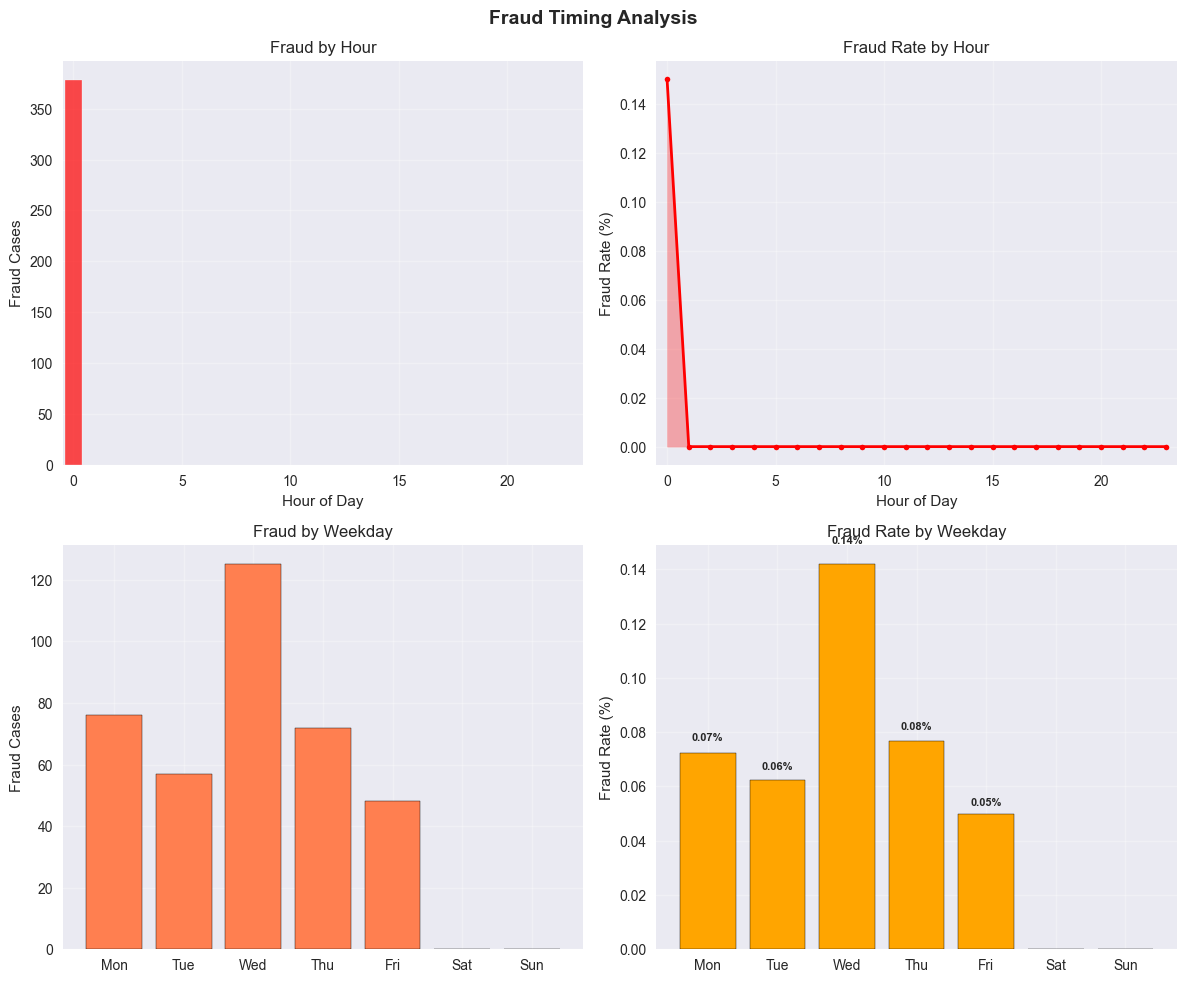


Timing Analysis:
- Peak hour: 0:00 (378 cases)
- Peak day: Wednesday (125 cases)


,Account ID,Member ID,Account Type,Account Open Date,Member Age,Product ID,Post Date,Post Time,Amount,Action Type,Source Type,Transaction Description,Fraud Adjustment Indicator,Is_Fraud,Amount_Range,Age_Group,Hour,Weekday
12509,3960000425,81908447,General Membership,2022-02-22,29,0007,2024-09-09,930,14.99,Deposit,NaN,NaN,9/6 ALBERT GENIUS RETURN-UNAUTH TRANS,True,$0-25,26-35,0,Monday
14059,1065072949,109702802,General Membership,2024-04-05,42,0007,2024-09-10,1010,51.99,Deposit,NaN,NaN,8/23 BRIGIT-COM RETURN-UNAUTH TRANS,True,$50-100,36-45,0,Tuesday
14060,1065072949,109702802,General Membership,2024-04-05,42,0007,2024-09-10,1010,8.99,Deposit,NaN,NaN,8/23 BRIGIT-COM RETURN-UNAUTH TRANS,True,$0-25,36-45,0,Tuesday
15507,3960000425,81908447,General Membership,2022-02-22,29,0007,2024-09-11,851,14.99,Deposit,NaN,NaN,9/11 ALBERT GENIUS RETURN-UNAUTH TRANS,True,$0-25,26-35,0,Wednesday
15515,6917521924,578759845,LLC,2021-03-23,0,0010,2024-09-11,937,106.12,Deposit,NaN,NaN,9/4 AVANT LLC 800-71 RETURN-UNAUTH TRANS,True,$100-200,18-25,0,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598854,89413929,703195926,General Membership,2022-12-15,22,0,2025-08-29,1011,500.00,Withdrawal,NaN,NaN,08/28 MOB DEP RET PER FRAUD DEPT,True,$500-1K,18-25,0,Friday
598856,89413929,703195926,General Membership,2022-12-15,22,0,2025-08-29,1012,500.00,Withdrawal,NaN,NaN,08/28 MOB DEP RET PER FRAUD DEPT,True,$500-1K,18-25,0,Friday
598857,89413929,703195926,General Membership,2022-12-15,22,0,2025-08-29,1013,500.00,Withdrawal,NaN,NaN,08/28 MOB DEP RET PER FRAUD DEPT,True,$500-1K,18-25,0,Friday
598858,89413929,703195926,General Membership,2022-12-15,22,0,2025-08-29,1014,500.00,Withdrawal,NaN,NaN,08/28 MOB DEP RET PER FRAUD DEPT,True,$500-1K,18-25,0,Friday


In [6]:
def analyze_fraud_timing(df):
    """Analyze fraud timing patterns"""
    fraud_df = df[df['Is_Fraud']].copy()

    # Parse time (HHMMSS format)
    def parse_time_to_hour(time_val):
        if pd.notna(time_val):
            time_str = str(int(time_val)).zfill(6)
            hour = int(time_str[:2])
            return hour
        return np.nan

    fraud_df['Hour'] = fraud_df['Post Time'].apply(parse_time_to_hour)
    df['Hour'] = df['Post Time'].apply(parse_time_to_hour)

    # Date analysis
    fraud_df['Weekday'] = fraud_df['Post Date'].dt.day_name()
    df['Weekday'] = df['Post Date'].dt.day_name()

    # Hourly and weekday analysis
    hourly_fraud = fraud_df['Hour'].value_counts().sort_index()
    hourly_total = df['Hour'].value_counts().sort_index()
    hourly_fraud_rate = (hourly_fraud / hourly_total * 100).fillna(0)

    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_fraud = fraud_df['Weekday'].value_counts().reindex(weekday_order).fillna(0)
    weekday_total = df['Weekday'].value_counts().reindex(weekday_order).fillna(0)
    weekday_rate = (weekday_fraud / weekday_total * 100).fillna(0)

    # Create visualization with smaller size
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Fraud Timing Analysis', fontsize=14, fontweight='bold')

    # 1. Hourly fraud distribution
    axes[0, 0].bar(hourly_fraud.index, hourly_fraud.values, color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Fraud Cases')
    axes[0, 0].set_title('Fraud by Hour')
    axes[0, 0].set_xlim(-0.5, 23.5)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Hourly fraud rate
    axes[0, 1].plot(hourly_fraud_rate.index, hourly_fraud_rate.values,
                    marker='o', linewidth=2, color='red', markersize=4)
    axes[0, 1].fill_between(hourly_fraud_rate.index, hourly_fraud_rate.values, alpha=0.3, color='red')
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel('Fraud Rate (%)')
    axes[0, 1].set_title('Fraud Rate by Hour')
    axes[0, 1].set_xlim(-0.5, 23.5)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Weekday fraud count
    bars = axes[1, 0].bar(range(len(weekday_fraud)), weekday_fraud.values,
                          color='coral', edgecolor='black')
    axes[1, 0].set_xticks(range(len(weekday_fraud)))
    axes[1, 0].set_xticklabels([day[:3] for day in weekday_order])
    axes[1, 0].set_ylabel('Fraud Cases')
    axes[1, 0].set_title('Fraud by Weekday')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Weekday fraud rate
    bars = axes[1, 1].bar(range(len(weekday_rate)), weekday_rate.values,
                          color='orange', edgecolor='black')
    axes[1, 1].set_xticks(range(len(weekday_rate)))
    axes[1, 1].set_xticklabels([day[:3] for day in weekday_order])
    axes[1, 1].set_ylabel('Fraud Rate (%)')
    axes[1, 1].set_title('Fraud Rate by Weekday')
    axes[1, 1].grid(True, alpha=0.3)


    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            axes[1, 1].text(bar.get_x() + bar.get_width() / 2., height + height * 0.05,
                            f'{height:.2f}%', ha='center', va='bottom',
                            fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print statistics
    peak_hour = hourly_fraud.idxmax() if len(hourly_fraud) > 0 else 'N/A'
    peak_day = weekday_fraud.idxmax()

    print(f"\nTiming Analysis:")
    print(f"- Peak hour: {peak_hour}:00 ({hourly_fraud.max() if len(hourly_fraud) > 0 else 0} cases)")
    print(f"- Peak day: {peak_day} ({weekday_fraud.max():.0f} cases)")

    return fraud_df

analyze_fraud_timing(df)

## Account Age Analysis
Analyze the relationship between account opening date and fraud occurrence

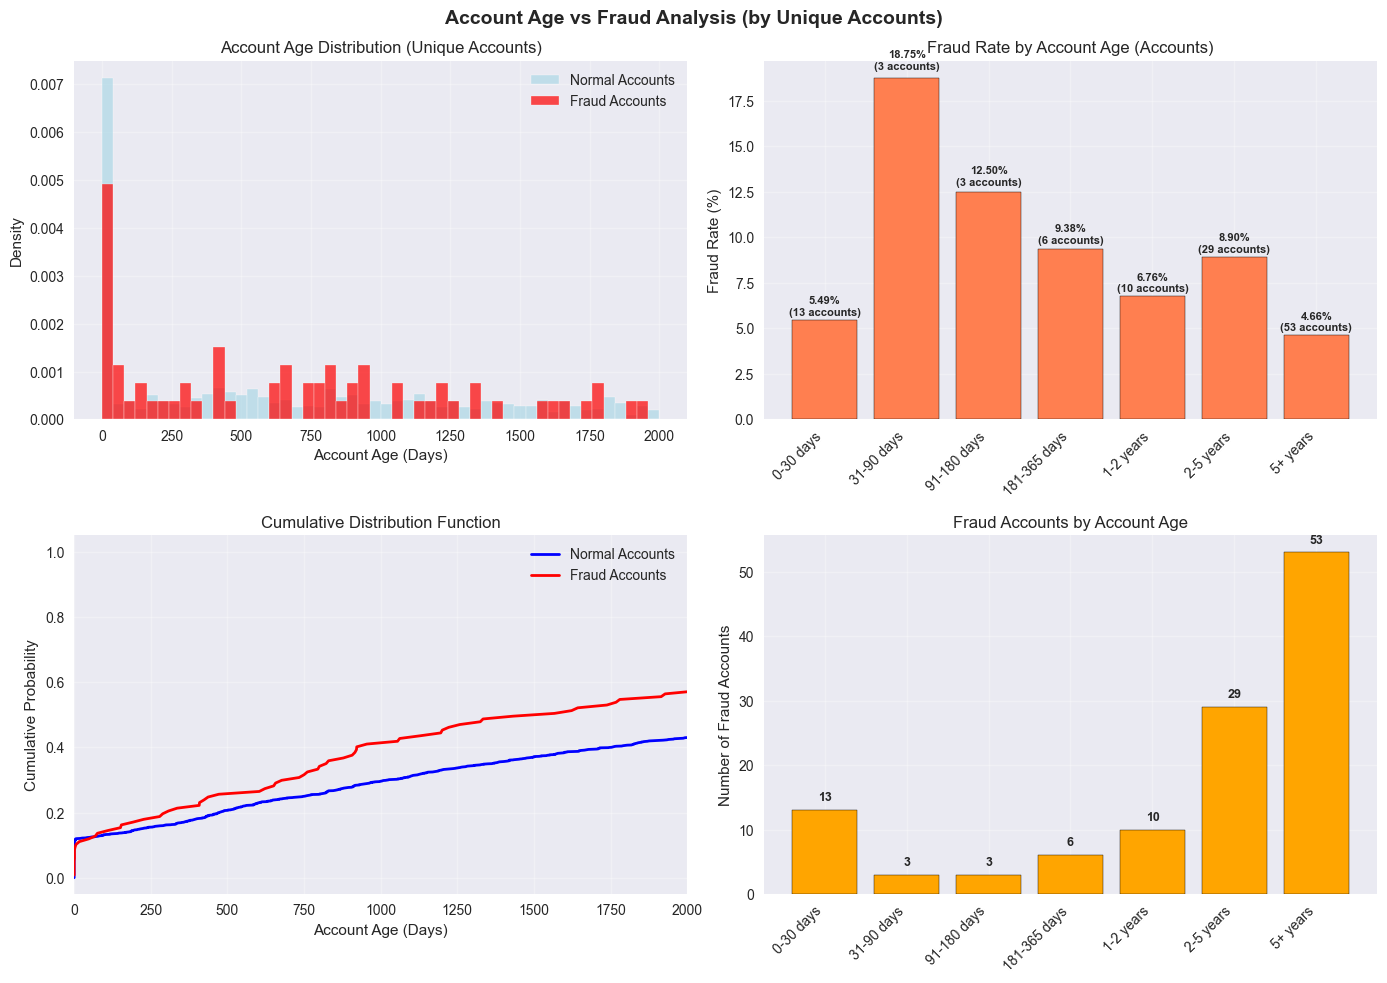


Account Age Statistics (Unique Accounts):
- Total unique accounts: 1,953
- Fraud accounts: 117
- Normal accounts: 1,836
- Overall fraud account rate: 5.99%

Normal Accounts:
  - Mean account age: 4605.0 days
  - Median account age: 2730.5 days
  - Std deviation: 5112.0 days

Fraud Accounts:
  - Mean account age: 3435.7 days
  - Median account age: 1567.0 days
  - Std deviation: 4330.9 days

Risk Analysis by Account Age (Unique Accounts):
  - 0-30 days: 13 fraud accounts / 237 total accounts (5.485% fraud rate)
  - 31-90 days: 3 fraud accounts / 16 total accounts (18.750% fraud rate)
  - 91-180 days: 3 fraud accounts / 24 total accounts (12.500% fraud rate)
  - 181-365 days: 6 fraud accounts / 64 total accounts (9.375% fraud rate)
  - 1-2 years: 10 fraud accounts / 148 total accounts (6.757% fraud rate)
  - 2-5 years: 29 fraud accounts / 326 total accounts (8.896% fraud rate)
  - 5+ years: 53 fraud accounts / 1138 total accounts (4.657% fraud rate)

Key Insights:
  - Highest risk perio

In [13]:
def analyze_account_age_vs_fraud(df):
    """Analyze relationship between account age and fraud occurrence - based on unique accounts"""

    # Calculate account age at time of transaction
    df['Account_Age_Days'] = (df['Post Date'] - df['Account Open Date']).dt.days

    # Remove negative values (invalid dates)
    df_clean = df[df['Account_Age_Days'] >= 0].copy()

    # Group by Account ID to get unique accounts
    # For each account, determine if it has any fraud cases and get account characteristics
    account_analysis = df_clean.groupby('Account ID').agg({
        'Is_Fraud': 'any',  # True if account has any fraud cases
        'Account_Age_Days': 'first',  # Account age should be consistent for same account
        'Amount': ['sum', 'count'],  # Total amount and transaction count
        'Member Age': 'first',  # Member age
        'Account Open Date': 'first',
        'Post Date': 'max'  # Latest transaction date
    }).reset_index()

    # Flatten column names
    account_analysis.columns = ['Account_ID', 'Has_Fraud', 'Account_Age_Days', 'Total_Amount',
                               'Transaction_Count', 'Member_Age', 'Account_Open_Date', 'Latest_Transaction']

    # Separate fraud accounts and normal accounts
    fraud_accounts = account_analysis[account_analysis['Has_Fraud']].copy()
    normal_accounts = account_analysis[~account_analysis['Has_Fraud']].copy()

    # Create age categories
    age_bins = [0, 30, 90, 180, 365, 730, 1825, float('inf')]
    age_labels = ['0-30 days', '31-90 days', '91-180 days', '181-365 days',
                  '1-2 years', '2-5 years', '5+ years']

    account_analysis['Account_Age_Category'] = pd.cut(account_analysis['Account_Age_Days'],
                                                     bins=age_bins, labels=age_labels, right=False)
    fraud_accounts['Account_Age_Category'] = pd.cut(fraud_accounts['Account_Age_Days'],
                                                   bins=age_bins, labels=age_labels, right=False)
    normal_accounts['Account_Age_Category'] = pd.cut(normal_accounts['Account_Age_Days'],
                                                    bins=age_bins, labels=age_labels, right=False)

    # Calculate fraud rate by account age (based on unique accounts)
    fraud_by_age = fraud_accounts['Account_Age_Category'].value_counts().sort_index()
    total_by_age = account_analysis['Account_Age_Category'].value_counts().sort_index()
    fraud_rate_by_age = (fraud_by_age / total_by_age * 100).fillna(0)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Account Age vs Fraud Analysis (by Unique Accounts)', fontsize=14, fontweight='bold')

    # 1. Account age distribution comparison
    axes[0, 0].hist(normal_accounts['Account_Age_Days'], bins=50, alpha=0.7,
                    label='Normal Accounts', density=True, color='lightblue', range=(0, 2000))
    axes[0, 0].hist(fraud_accounts['Account_Age_Days'], bins=50, alpha=0.7,
                    label='Fraud Accounts', density=True, color='red', range=(0, 2000))
    axes[0, 0].set_xlabel('Account Age (Days)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Account Age Distribution (Unique Accounts)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Fraud rate by account age category
    bars = axes[0, 1].bar(range(len(fraud_rate_by_age)), fraud_rate_by_age.values,
                          color='coral', edgecolor='black')
    axes[0, 1].set_xticks(range(len(age_labels)))
    axes[0, 1].set_xticklabels(age_labels, rotation=45, ha='right')
    axes[0, 1].set_ylabel('Fraud Rate (%)')
    axes[0, 1].set_title('Fraud Rate by Account Age (Accounts)')
    axes[0, 1].grid(True, alpha=0.3)

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i < len(fraud_by_age):
            axes[0, 1].text(bar.get_x() + bar.get_width() / 2., height + height * 0.02,
                            f'{height:.2f}%\n({fraud_by_age.iloc[i]} accounts)',
                            ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 3. Account age cumulative distribution
    normal_sorted = np.sort(normal_accounts['Account_Age_Days'])
    fraud_sorted = np.sort(fraud_accounts['Account_Age_Days'])
    normal_cumulative = np.arange(1, len(normal_sorted) + 1) / len(normal_sorted)
    fraud_cumulative = np.arange(1, len(fraud_sorted) + 1) / len(fraud_sorted)

    axes[1, 0].plot(normal_sorted, normal_cumulative, label='Normal Accounts',
                    color='blue', linewidth=2)
    axes[1, 0].plot(fraud_sorted, fraud_cumulative, label='Fraud Accounts',
                    color='red', linewidth=2)
    axes[1, 0].set_xlabel('Account Age (Days)')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution Function')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 2000)

    # 4. Fraud account count by account age category
    bars = axes[1, 1].bar(range(len(fraud_by_age)), fraud_by_age.values,
                          color='orange', edgecolor='black')
    axes[1, 1].set_xticks(range(len(age_labels)))
    axes[1, 1].set_xticklabels(age_labels, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Number of Fraud Accounts')
    axes[1, 1].set_title('Fraud Accounts by Account Age')
    axes[1, 1].grid(True, alpha=0.3)

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2., height + 1,
                        f'{int(height)}', ha='center', va='bottom',
                        fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Statistical analysis based on unique accounts
    print(f"\nAccount Age Statistics (Unique Accounts):")
    print(f"- Total unique accounts: {len(account_analysis):,}")
    print(f"- Fraud accounts: {len(fraud_accounts):,}")
    print(f"- Normal accounts: {len(normal_accounts):,}")
    print(f"- Overall fraud account rate: {len(fraud_accounts)/len(account_analysis)*100:.2f}%")

    print(f"\nNormal Accounts:")
    print(f"  - Mean account age: {normal_accounts['Account_Age_Days'].mean():.1f} days")
    print(f"  - Median account age: {normal_accounts['Account_Age_Days'].median():.1f} days")
    print(f"  - Std deviation: {normal_accounts['Account_Age_Days'].std():.1f} days")

    print(f"\nFraud Accounts:")
    print(f"  - Mean account age: {fraud_accounts['Account_Age_Days'].mean():.1f} days")
    print(f"  - Median account age: {fraud_accounts['Account_Age_Days'].median():.1f} days")
    print(f"  - Std deviation: {fraud_accounts['Account_Age_Days'].std():.1f} days")

    # Risk analysis by account age
    print(f"\nRisk Analysis by Account Age (Unique Accounts):")
    for i, label in enumerate(age_labels):
        if i < len(fraud_rate_by_age) and fraud_rate_by_age.iloc[i] > 0:
            print(f"  - {label}: {fraud_by_age.iloc[i]} fraud accounts / {total_by_age.iloc[i]} total accounts ({fraud_rate_by_age.iloc[i]:.3f}% fraud rate)")

    # Find highest risk period
    if len(fraud_rate_by_age) > 0 and fraud_rate_by_age.max() > 0:
        highest_risk_idx = fraud_rate_by_age.idxmax()
        highest_risk_position = list(fraud_rate_by_age.index).index(highest_risk_idx)
        highest_risk_category = age_labels[highest_risk_position]
        highest_risk_rate = fraud_rate_by_age.iloc[highest_risk_position]

        print(f"\nKey Insights:")
        print(f"  - Highest risk period: {highest_risk_category} ({highest_risk_rate:.3f}% fraud rate)")

        if len(fraud_rate_by_age) > 0:
            print(f"  - New accounts (0-30 days): {fraud_rate_by_age.iloc[0]:.3f}% fraud rate")
        if len(fraud_rate_by_age) >= 7:
            print(f"  - Mature accounts (5+ years): {fraud_rate_by_age.iloc[6]:.3f}% fraud rate")


    return fraud_accounts, normal_accounts, account_analysis

# Run the analysis
fraud_accounts, normal_accounts, all_accounts = analyze_account_age_vs_fraud(df)